## Import libraries

In [ ]:
! pip install shap
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 27.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=f754af414b6dec0f9d019d8b3a145b3915e9848b7e7eeceaad46f6692f40ede8
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


## VGG

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import shap
# import keras.backend as K
import json

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from skimage.segmentation import mark_boundaries

In [ ]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)

X,y = shap.datasets.imagenet50()
# to_explain = X[[39,41]]


553467096/553467096 [==============================] - 4s 0us/step


## Lime

In [ ]:
# from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
import keras.utils as image
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.utils import img_to_array
from skimage.io import imread
import matplotlib.pyplot as plt
import lime
from lime import lime_image


In [ ]:
def reshape_img(to_explain):
  img = image.img_to_array(to_explain)
  img = np.expand_dims(img, axis=0)
  return(img)

def normalize_img(to_explain):
  norm_img = image.img_to_array(to_explain)# Transforming the image to get the shape as [channel, height, width]
  norm_img = np.expand_dims(norm_img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
  norm_img = norm_img/255.0
  return(norm_img)


In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.001, show_positive = True, hide_background = True):
    #weight = 0.1, 0.01
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    return(mark_boundaries(image, mask))

def explanation_heatmap(exp, exp_class,image_no, top_prediction):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.title(str(top_prediction), fontsize=14)
    plt.savefig('heatmap_' + str(image_no)+'.png')

  0%|          | 0/10 [00:00<?, ?it/s]

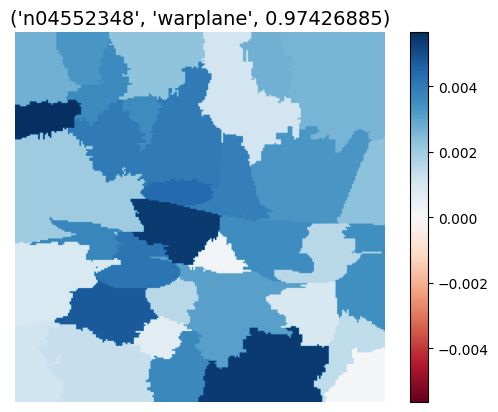

In [ ]:
for i in range(49,50):
    to_explain = X[i]
    img = reshape_img(to_explain)
    norm_img =normalize_img(to_explain)

    model_prediction = model.predict(img)
    top5_pred = decode_predictions(model_prediction, top=5)[0]

    explainer = lime_image.LimeImageExplainer()

    exp = explainer.explain_instance(norm_img[0],
                                    model.predict, 
                                    top_labels=5, 
                                    hide_color=0, 
                                    num_samples=10)

    # #lime explanations  
    #taking the top label, we look at areas of the image that was used to predict this label 
    plt.imshow(exp.segments)
    plt.axis('off')
    plt.title(str(top5_pred[0]), fontsize=14)
    plt.savefig('lime_segment_'+str(i)+'.png')

    #super pixel explanations
    top_segments= generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)
    plt.imshow(top_segments)
    plt.title(str(top5_pred[0]), fontsize=14)
    plt.savefig('test_top_seg_' + str(i)+'.png')

    #heatmap explanations
    heatmap = explanation_heatmap(exp, exp.top_labels[0], i, top5_pred[0])


In [ ]:
# generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)
# generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False) --> shows segmentation of super pixels with background
# generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)


#### Initial test runs with a couple images

In [ ]:
model_prediction = model.predict(img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

speedboat
lifeboat
amphibian
wreck
submarine


In [ ]:
explainer = lime_image.LimeImageExplainer()

exp = explainer.explain_instance(norm_img[0],
    # normalized_img[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

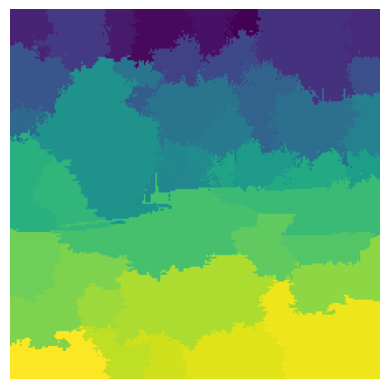

In [ ]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

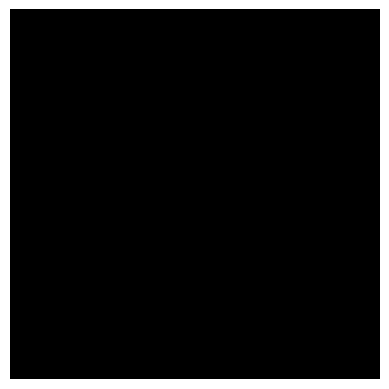

In [ ]:

generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

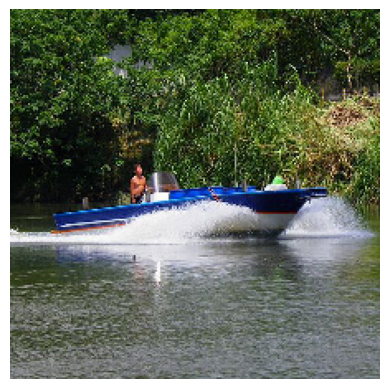

In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)


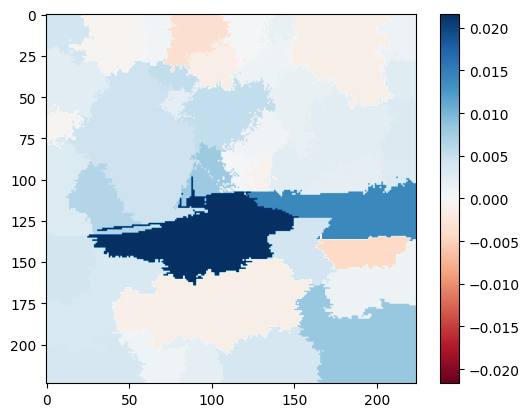

In [ ]:
explanation_heatmap(exp, exp.top_labels[0])

We tried adjusting the threshold to identify superpixel segmentations

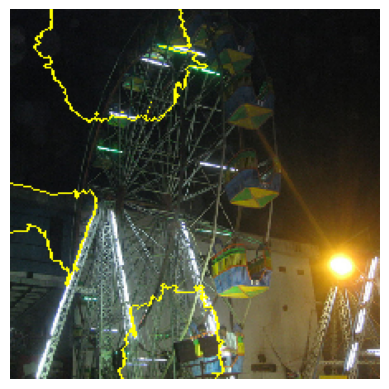

<Figure size 640x480 with 0 Axes>

In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)
plt.savefig('lime_seg_test.png')

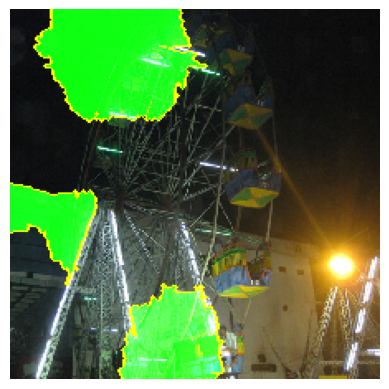

In [ ]:
# plt.savefig('image_'+str(i)+'.png')


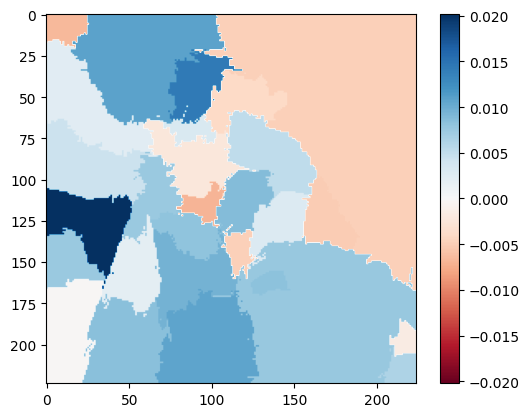

In [ ]:
explanation_heatmap(exp, exp.top_labels[0])